### Amazon Data Sales
Inlämningsuppgift 2: Anders Viklund BI23  
Deadline: 2024-02-04 23:59

In [141]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [142]:
# Load dataset
df = pd.read_csv('AmazonDataSales.csv')
df.head(3)

C:\Users\ander\AppData\Local\Temp\ipykernel_15660\5467653.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('AmazonDataSales.csv')


,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN


In [143]:
# Get info about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128975 entries, 0 to 128974
Data columns (total 24 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               128975 non-null  int64  
 1   Order ID            128975 non-null  object 
 2   Date                128975 non-null  object 
 3   Status              128975 non-null  object 
 4   Fulfilment          128975 non-null  object 
 5   Sales Channel       128975 non-null  object 
 6   ship-service-level  128975 non-null  object 
 7   Style               128975 non-null  object 
 8   SKU                 128975 non-null  object 
 9   Category            128975 non-null  object 
 10  Size                128975 non-null  object 
 11  ASIN                128975 non-null  object 
 12  Courier Status      122103 non-null  object 
 13  Qty                 128975 non-null  int64  
 14  currency            121180 non-null  object 
 15  Amount              121180 non-nul

In [144]:
# Count null values
num_rows = df.shape[0]

data = {
    'Column': [],
    'Non-Null Count': [],
    'Dtype': []
}

for column in df.columns:
    data['Column'].append(column)
    data['Non-Null Count'].append(df[column].count())
    data['Dtype'].append(df[column].dtype)

info_df = pd.DataFrame(data)

info_df['Null Count'] = num_rows - info_df['Non-Null Count']

info_df['Percentage'] = ((info_df['Null Count']/num_rows)*100).round(2)

columns_disp = ['Column','Dtype','Non-Null Count','Null Count','Percentage']

#Sorting
column_name = 'Percentage'
info_df_sorted = info_df.sort_values(by=column_name, ascending=False)
info_df_sorted[columns_disp].head(7)


,Column,Dtype,Non-Null Count,Null Count,Percentage
22,fulfilled-by,object,39277,89698,69.55
20,promotion-ids,object,79822,49153,38.11
23,Unnamed: 22,object,79925,49050,38.03
14,currency,object,121180,7795,6.04
15,Amount,float64,121180,7795,6.04
12,Courier Status,object,122103,6872,5.33
19,ship-country,object,128942,33,0.03


In [145]:
# Drop columns with high percentage of null values
columns_to_drop = ['fulfilled-by','promotion-ids','Unnamed: 22']
df = df.drop(columns=columns_to_drop)
df.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,ASIN,Courier Status,Qty,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,B09KXVBD7Z,NaN,0,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,B09K3WFS32,Shipped,1,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False


In [146]:
# Handle NaN values

# Currency

df['currency'] = df['currency'].ffill()

df['currency'].count()

# Amount

mean_value = df['Amount'].mean()

df['Amount'] = df['Amount'].fillna(mean_value)

df['Amount'].count()

# Courier status

df['Courier Status'] = df['Courier Status'].fillna('Unknown')

df['Courier Status'].count()

# Ship country
# Remove rows with ship country == nan (33 rows)

df.drop(df[df['ship-country'].isna()].index, inplace=True)

df.count()



index                 128942
Order ID              128942
Date                  128942
Status                128942
Fulfilment            128942
Sales Channel         128942
ship-service-level    128942
Style                 128942
SKU                   128942
Category              128942
Size                  128942
ASIN                  128942
Courier Status        128942
Qty                   128942
currency              128942
Amount                128942
ship-city             128942
ship-state            128942
ship-postal-code      128942
ship-country          128942
B2B                   128942
dtype: int64

In [147]:
# Relevant columns
features = ['Category','Size','Qty']
target = ['Amount']

df_features = df[features]

columns_to_keep = features + target

df = df[columns_to_keep]

In [148]:
# Frequency lists
for i in df_features.columns:
    frequency_list = df_features[i].value_counts()
    print(frequency_list)
    print(f"\nSum of frequencies: {frequency_list.sum()}")
    print(f"------------------------------")

Category
Set              50272
kurta            49859
Western Dress    15499
Top              10620
Ethnic Dress      1159
Blouse             926
Bottom             440
Saree              164
Dupatta              3
Name: count, dtype: int64

Sum of frequencies: 128942
------------------------------
Size
M       22704
L       22123
XL      20872
XXL     18093
S       17084
3XL     14815
XS      11160
6XL       738
5XL       550
4XL       425
Free      378
Name: count, dtype: int64

Sum of frequencies: 128942
------------------------------
Qty
1     115752
0      12802
2        341
3         32
4          9
5          2
15         1
9          1
13         1
8          1
Name: count, dtype: int64

Sum of frequencies: 128942
------------------------------


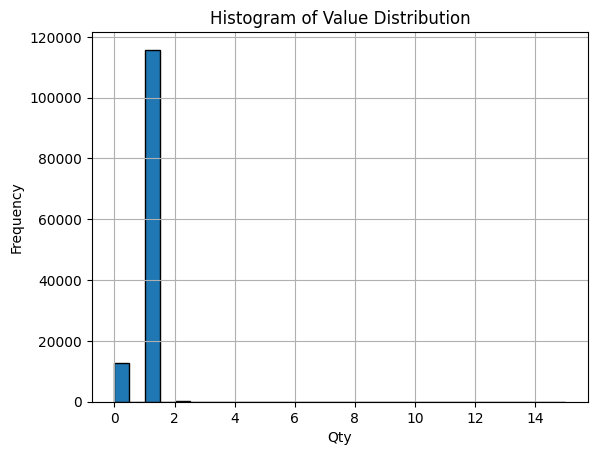

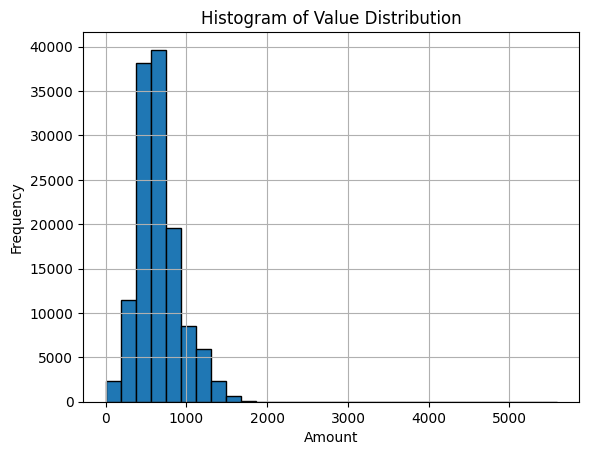

In [149]:
# Assuming df is your DataFrame and 'column_name' is the column you want to plot
df['Qty'].hist(bins=30, edgecolor='black')

plt.title('Histogram of Value Distribution')
plt.xlabel('Qty')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Assuming df is your DataFrame and 'column_name' is the column you want to plot
df['Amount'].hist(bins=30, edgecolor='black')

plt.title('Histogram of Value Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [150]:
# Encoding of categorical columns
df_encoded = pd.get_dummies(df, columns=['Category','Size'])

df = df_encoded

In [151]:
# Convert True/False to 1/0

bool_columns = df.select_dtypes(include='bool')

for i in bool_columns:
    df[i] = df[i].astype(int)

df

,Qty,Amount,Category_Blouse,Category_Bottom,Category_Dupatta,Category_Ethnic Dress,Category_Saree,Category_Set,Category_Top,Category_Western Dress,...,Size_4XL,Size_5XL,Size_6XL,Size_Free,Size_L,Size_M,Size_S,Size_XL,Size_XS,Size_XXL
0,0,647.62,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,406.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,329.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,753.33,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1,574.00,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,1,517.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
128971,1,999.00,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
128972,1,690.00,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
128973,1,1199.00,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [152]:
# Scaling of numerical columns
scaler = StandardScaler()

# Fit and transform the column
df['Qty'] = scaler.fit_transform(df[['Qty']])

df['Amount'] = scaler.fit_transform(df[['Amount']])

df

,Qty,Amount,Category_Blouse,Category_Bottom,Category_Dupatta,Category_Ethnic Dress,Category_Saree,Category_Set,Category_Top,Category_Western Dress,...,Size_4XL,Size_5XL,Size_6XL,Size_Free,Size_L,Size_M,Size_S,Size_XL,Size_XS,Size_XXL
0,-2.886479,-0.003495,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.304956,-0.889880,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.304956,-1.172355,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-2.886479,0.384304,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0.304956,-0.273570,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128970,0.304956,-0.482675,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
128971,0.304956,1.285546,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
128972,0.304956,0.151977,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
128973,0.304956,2.019248,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [153]:
# Vald modell: LinearRegression

df.head(3)

X = df.drop('Amount', axis=1)

y = df['Amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.6129463425375699
R-squared: 0.38774917216524807


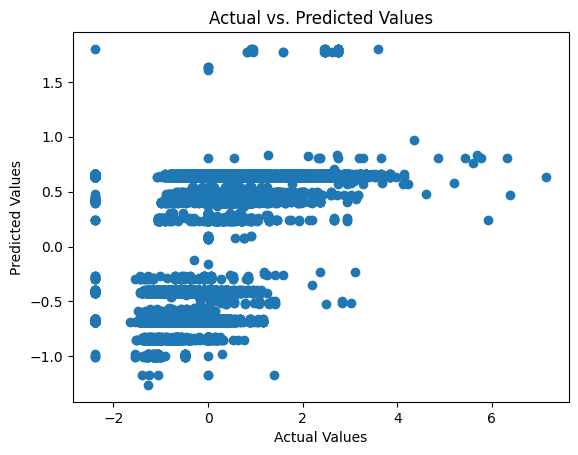

In [154]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()
